# Biophysics project - Monte Carlo simulation of polymer folding

Date: 06.02.2024

Authors: Vemund Aakre, Thorbjørn Djupvik and Oskar Feed Jakobsen


---

Chains of amino acids are the the building blocks of proteins.
These will fold themeselves in the three dimensional space, and thus, chemical bonding between non-neighbouring parts of the chain will occur.
The generalization of such three-dimensional structures are called *polymers*. A polymer consists of repeating units called *monomers*.
In this project, we will simulate polymer folding in two dimension.
By using methods of Monte Carlo simulation we will investigate physical properties of polymers.
The energy and the spacial extent of the structures, in addition to how these depend on temperature, are quantities that we will take a closer look at.

---

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
from numba import njit
from scipy.constants import Boltzmann
from typing import Callable

## The representation of a polymer
To represent a two dimensional polymer, one may try to create a two dimensional matrix to represent 2D space
and denote with for example 1 or 0 whether a monomer is located at a point in space or not. This will in general be 
unsuitable when scaling the problem, since the size of the matrix scales as $N^2$ with the size of the polymer. This also 
results in a higher computation time, because every computation done with the polymer requires iterating through the entire 
matrix. As most of the indices will be zero, this is a waste of space and time, and can be optimized.

A more efficient way of representing the polymer is just to store its monomer coordinates in a $N\times2$ matrix, reducing 
the matrix size to scale linearly with the size of the polymer. In our implementation the matrix has a size of $N\times2$, 
where each row contains the coordinate of a single monomer, $(x, y)$. The order of the rows is set to be the order
in which they appear in the polymer. For a polymer of size N, the structure would look like this:

$$
  \begin{bmatrix}
   x_1& y_1\\
   x_2& y_2\\
   \vdots&\vdots \\
   x_N& y_N\\
  \end{bmatrix}
$$

### A couple of conventions
Following the naming convention of the project description, we will name the first monomer 'monomer 1', and not by its index 
in the matrix. We will also define the head of a polymer with respect to a given monomer $i$, to be all monomers $j$
where $j<i$. The tail is defined identically for $j>i$.


## Polymers in action
To be able to work with polymers in the code, it is nice to have a function to automatically create a polymer of a given size 
without having to manually type it into the code.
The function `generate_flat_polymer` generates a flat polymer of a given length centered around the origin.

In [120]:
@njit
def generate_flat_polymer(
    polymer_length: int, mid_of_polymer: np.ndarray = np.zeros(2)
) -> np.ndarray:
    """Generates a horizontal polymer with N (polymer_length) monomers

    Args:
        polymer_length (int): Number of monomers
        mid_of_polymer (np.ndarray, optional): The coordinates of the center monomer. Defaults to np.zeros(2).

    Returns:
        np.ndarray: the generated polymer
    """
    polymer_array = np.zeros((polymer_length, 2), dtype=np.int32)
    polymer_start = -int(polymer_length / 2) + mid_of_polymer[0]
    # + 1/2 to handle even numbers
    polymer_end = int((polymer_length + 1) / 2) + mid_of_polymer[0]
    polymer_array[:, 1] = mid_of_polymer[1]
    polymer_array[:, 0] = np.arange(polymer_start, polymer_end, 1, dtype=np.int32)

    return polymer_array

It is beneficial to be able to visualize the polymers whilst working with them. This helps debugging the code and analyzing the problems at hand.
The function `illustrate_polymer` displays the polymer in a grid of size $N\times N$ with a color gradient to separate the 
monomers from each other.

In [121]:
def illustrate_polymer(
    ax,
    polymer: np.ndarray,
    cmap: str = "Greens",
    numbers: bool = False,
    title: str = ""
) -> None:
    """
    Uses matplotlib.pyplot.pcolormesh to illustrate a polymer.

    Args:
        ax: Axes to plot on
        polymer: Nx2-dimensional array containing coordinates for the N monomers
        cmap: matplotlib colormap
        number: Defaults to False. If True the monomers will display their index
        title: Title
        
    Returns:
        None
    """
    # Make a NxN-grid
    N = len(polymer)
    x = y = np.arange(N + 1)
    Z = np.zeros((N, N))

    # Placing the polymer on the grid such that the middle monomer is in the center.
    middle_monomer = polymer[int(N / 2)]
    for i, monomer in enumerate(polymer):
        # Shifting by 1 if N is even and middle monomer has negative coordinates
        shifty = (1 if N % 2 == 0 and middle_monomer[1] < 0 else 0)
        shiftx = (1 if N % 2 == 0 and middle_monomer[0] < 0 else 0)
        x_coord = monomer[1] + int(N / 2) - middle_monomer[1] - shifty
        y_coord = monomer[0] + int(N / 2) - middle_monomer[0] - shiftx
        Z[x_coord, y_coord] = i + 9
        if numbers:
            ax.text(y_coord + 0.5, x_coord + 0.5, i + 1, size="x-large", color='red')

    ax.pcolormesh(x, y, Z, shading="flat", cmap=cmap)
    ax.set(title=title, xticks=x, xticklabels=[], yticks=y, yticklabels=[])
    ax.tick_params(axis="both", left=False, right=False, bottom=False, top=False)
    ax.grid(True)

Let us use `illustrate_polymer` to get a sense of how a flat polymer consisting of 10 monomers looks like. The numbers $1$ through $10$ walks the polymer from it's head to it's tail.

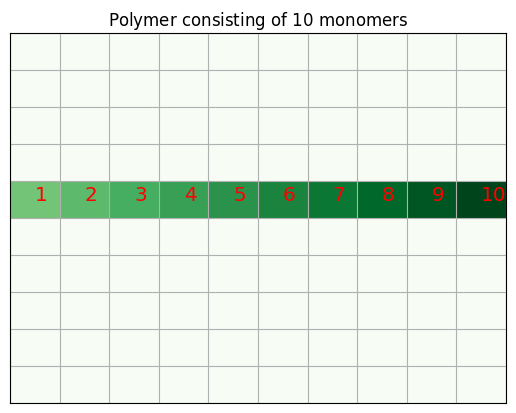

In [122]:
polymer = generate_flat_polymer(polymer_length=10)
fig, ax = plt.subplots()
illustrate_polymer(ax, polymer, numbers=True, cmap="Greens", title="Polymer consisting of $10$ monomers")
plt.show()

### Validation

As per the project description, our model is a simplified 2D-model of polymers, and the polymers are therefore subject to 
certain restrictions. A polymer of size $N$ is only considered *intact* if it satisfies the following rules:

1. It has $N$ monomers.
2. Each monomer is represented by a unique integer $m \in [1, N]$. This means that no monomer is represented by the same number as another monomer.
3. A monomer represented by the integer $m$ is the closest neighbour to the monomers represented by the integers $m-1$ and $m+1$. Monomers at the ends, $m=1$ and $m=N$, need only to be closest neighbour to $m=2$ and $m=N-1$ respectivly. Two monomers are closest neighbours if the distance between them is exactly equal to one.
4. Two monomers do not occupy the same space simultaneously. 

Thus, when trying to fold a polymer, we always have to check its validity before attempting to operate on it. The functions 
defined underneath all implements the validation-logic. An important thing to note is that the validation function needs to 
be fast. When running the simulation, it might get called multiple times for every Monte Carlo step. This means that the time 
the program spends in this function accumulates quickly to a considerable size when running the simulation functions we will 
define in a later section.
Here are three different implementations, ordered by the time of writing, where we have tried to optimize the time spent.

The first one is a for-loop implementation. It has the benefit of an early return if the polymer is not intact when checking 
the distances between neighbouring monomers. Method 2 
on the other hand will always run the worst case scenario and check all the distances before returning. However it is,
completely implemented with *NumPy* functions, and for that reason it is actually faster as we will see in the [Benchmarks](#Benchmarks) 
section. The last implementation uses *Numba* to 
Just-In-Time compile the function, also known as JIT-compiling. Because *Numba* does not support np.unique with axis specified, we had to rewrite that part to python 
for-loops. Here we could again utilize the early return optimization, but now when checking for overlap in the polymer.

We 
will return to the details of these implementations when we discuss the time usage in the [Benchmarks](#Benchmarks) section, but for now 
it can 
be said that `check_if_intact` is the fastest of them, and the one we will use."

In [123]:
def check_if_intact_1(polymer: np.ndarray, polymer_length: int) -> bool:
    """Checks if polymer is intact

    Args:
        polymer (np.ndarray): The polymer to check
        polymer_length (int): Length of the polymer

    Returns:
        bool: True if the polymer is intact
    """
    # Checks that the polymer has N monomers, where each has a unique whole number representation
    if np.size(np.unique(polymer, axis=0), axis=0) != polymer_length:
        return False

    for i in range(1, polymer_length):
        # Don't have to take the square root (faster), as any value different from 1 indicates a broken polymer anyway.
        distance = (polymer[i - 1, 0] - polymer[i, 0]) ** 2 + (
            polymer[i - 1, 1] - polymer[i, 1]
        ) ** 2
        if distance != 1:
            return False
    return True

In [124]:
def check_if_intact_2(polymer: np.ndarray, polymer_length: int) -> bool:
    """Checks if polymer is intact

    Args:
        polymer (np.ndarray): The polymer to check
        polymer_length (int): Length of the polymer

    Returns:
        bool: True if the polymer is intact
    """
    # Checks that the polymer has N monomers, where each has a unique whole number representation
    if np.size(np.unique(polymer, axis=0), axis=0) != polymer_length:
        return False

    test = polymer[1:]
    test_mot = polymer[:-1]
    # Don't have to take the square root or square (faster), as any value different from 1 indicates a broken polymer anyway.
    distance_array = np.abs(test[:, 0] - test_mot[:, 0]) + np.abs(
        test[:, 1] - test_mot[:, 1]
    )
    if np.any(distance_array != 1):
        return False
    return True

In [125]:
@njit
def check_if_intact(polymer: np.ndarray, polymer_length: int) -> bool:
    """Checks if polymer is intact

    Args:
        polymer (np.ndarray): polymer that is checked
        polymer_length (int): length of the polymer

    Returns:
        bool: True if polymer is intact
    """

    if len(polymer) != polymer_length:
        return False

    unique_monomer = np.zeros_like(polymer)
    # First monomer is always unique
    unique_monomer[0] = polymer[0]

    # Does not have to check the first monomer
    for i in range(1, polymer_length):
        for j in range(i):
            # checks that the monomer's coordinates are not similar to a previous monomer
            if (
                polymer[i, 0] == unique_monomer[j, 0]
                and polymer[i, 1] == unique_monomer[j, 1]
            ):
                return False
            else:
                unique_monomer[i] = polymer[i]

    test = polymer[1:]
    test_against = polymer[:-1]
    # Don't need squareroot since all other values than 1 means that it is not intact
    distance_array = (test[:, 0] - test_against[:, 0]) ** 2 + (
        test[:, 1] - test_against[:, 1]
    ) ** 2

    # If distance-array contains anything other than 1, the polymer is not intact
    if np.any(distance_array != 1):
        return False
    return True

### Rotation

To rotate a polymer around a given monomer, we only need to look at the relative position between the rotation center and the 
monomers which are to be rotated. Let's denote the coordinates of the rotation center as $(x_s, y_s)$, and of an arbitrary 
monomer as $(x_0, y_0)$. Then the relative position of the monomer with respect to the rotation center is given by
$$
    (x_{0, \text{rel}}, y_{0, \text{rel}}) = (x_0-x_s, y_0-y_s).
$$
When the monomer is rotated, the new relative coordinates in terms of the old ones is
$$
    (x_{1, \text{rel}}, y_{1, \text{rel}}) = k \cdot (- y_{0, \text{rel}}, x_{0, \text{rel}}),
$$
where $k=1$ if the rotation is in the positive direction, and $k=-1$ if it is in the negative direction.
The new coordinates of the monomer then becomes
$$
    (x_{\text{rot}}, y_{\text{rot}}) = (x_s, y_s) + k \cdot (-y_{\text{rel}}, x_{\text{rel}}) = (x_s, y_s) + k \cdot (-(y_0 - y_s), x_0 - x_s).
$$
When implementing this, one can make a small optimization by always rotating the shortest end of the polymer with respect 
to the rotation center. This reduces the number of computations and ensures that the center of the polymer does not move too 
much when rotating. This behaviour implies that in the case of a rotation around one of the two end polymers, nothing will get rotated. In the case that the head and tail are equally long, it does not matter which one gets rotated. In our
implementation we have defined it to just rotate the tail. In order to speed up the function, we have utilised *NumPy*,
slicing and *Numba* JIT-compiling. We will expand on this and the difference between the two versions in the [Benchmarks](#Benchmarks) section.


In [126]:
@njit
def rotate_polymer(
    polymer: np.ndarray, rotation_center: int, positive_direction: bool = True
) -> np.ndarray:
    """Rotates a polymer in the given direction around a monomer

    Args:
        polymer: A 2D numpy array with monomer coordinates

        rotation_center: Which monomer to rotate around
        `Note: It is not the index, but the monomer_number. [1, N]`

        positive_direction: Rotate in the positive direction if True, or negative direction if False

    Returns:
        a rotated copy of the polymer
    """
    # Make a slicing array to rotate the correct end of the polymer
    rotation_slice = np.full(len(polymer), False)

    # Choose to rotate the shortest tail of the polymer
    if rotation_center >= len(polymer) / 2:
        rotation_slice[rotation_center:] = True
    else:
        rotation_slice[:rotation_center] = True

    if positive_direction:
        direction = 1
    else:
        direction = -1

    # The coordinates in space of the rotation center
    rotation_position = polymer[rotation_center - 1]

    # Where _rel means the position relative to the rotation center
    # new_x = x_s + new_x_rel
    # new_y = y_s + new_y_rel
    # new_x_rel = - (y - y_s) * direction
    # new_y_rel = (x - x_s) * direction
    new_pos_rel = ((polymer[rotation_slice] - rotation_position) * direction)[:, ::-1]
    new_pos_rel[:, 0] *= -1  # Changes the sign of the x-values

    # Makes a copy of the polymer
    new_polymer = polymer.copy()

    new_polymer[rotation_slice] = rotation_position + new_pos_rel
    return new_polymer

In [127]:
@njit
def rotate_polymer_mut(
    polymer: np.ndarray, rotation_center: int, positive_direction: bool = True
) -> np.ndarray:
    """Rotates a polymer in the given direction around a monomer

    Args:
        polymer: A 2D numpy array with monomer coordinates

        rotation_center: Which monomer to rotate around
        `Note: It is not the index, but the monomer_number. [1, N]`

        positive_direction: Rotate in the positive direction if True, or negative direction if False

    Returns:
        a rotated copy of the polymer
    """
    # Make a slicing array to rotate the correct end of the polymer
    rotation_slice = np.full(len(polymer), False)

    # Choose to rotate the shortest tail of the polymer
    if rotation_center >= len(polymer) / 2:
        rotation_slice[rotation_center:] = True
    else:
        rotation_slice[:rotation_center] = True

    if positive_direction:
        direction = 1
    else:
        direction = -1

    # The coordinates in space of the rotation center
    rotation_position = polymer[rotation_center - 1]

    # Where _rel means the position relative to the rotation center
    # new_x = x_s + new_x_rel
    # new_y = y_s + new_y_rel
    # new_x_rel = - (y - y_s) * direction
    # new_y_rel = (x - x_s) * direction
    new_pos_rel = ((polymer[rotation_slice] - rotation_position) * direction)[:, ::-1]
    new_pos_rel[:, 0] *= -1  # Changes the sign of the x-values

    polymer[rotation_slice] = rotation_position + new_pos_rel
    return polymer

## Simulation
Up until now we have defined basic functions to operate on the polymers. Here we will define a bigger function to simulate,
multiple rotations, so we can see how the polymers behave when allowed to rotate multiple times. With this we will also be
able to benchmark the different variants
of the functions above to see which perform the best.

In [128]:
@njit
def simulate_rotations(N: int, Ns: int) -> tuple[np.ndarray, int]:
    """Simulates rotations of the polymer.
    Implementation of algorithm 1 in project description.

    Args:
        N: length of polymer.
        Ns: number of twists (attempts) to be performed.

    Returns:
        (polymer, number of seccessful twists.)
    """
    counter = 1
    pol = generate_flat_polymer(N)
    for _ in range(Ns):
        # random monomer and random twisting direction
        # [2, N) makes sure the end monomers are not chosen as rotation centers
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        twisted_pol = rotate_polymer(pol, rnd_monomer, rnd_rotate)
        valid = check_if_intact(twisted_pol, N)
        if valid:
            counter += 1
            pol = twisted_pol

    return pol, counter

Let us run `simulate_rotations` and visualize the results. First with $N = 15$ and $N_s = 4$, then with $N = 15$ and $N_s = 1000$.
<a id="simulation_visualization"></a>

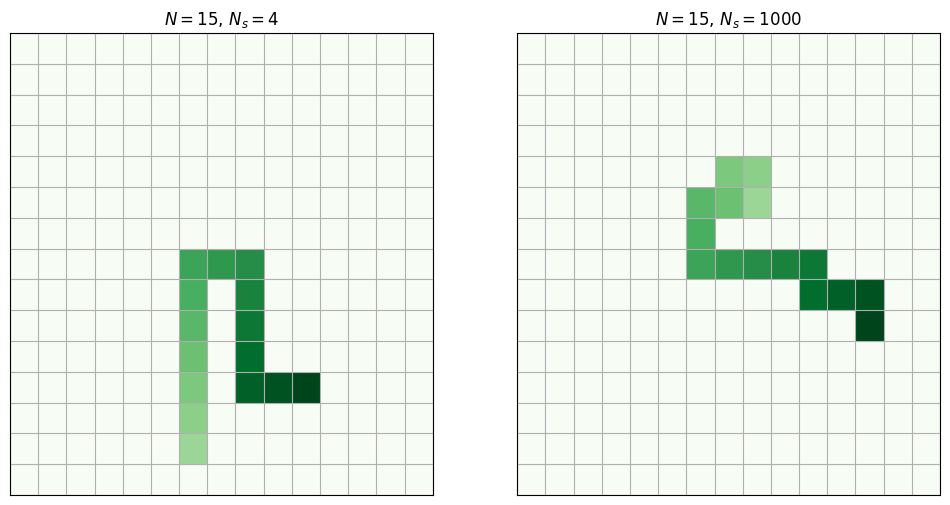

In [129]:
N = 15
polymer_1, _ = simulate_rotations(N = N, Ns = 4)
polymer_2, _ = simulate_rotations(N = N, Ns = 1000)

fig, axs = plt.subplots(1, 2, figsize=(12,6))
illustrate_polymer(axs[0], polymer_1, cmap="Greens", title="$N = 15$, $N_s = 4$")
illustrate_polymer(axs[1], polymer_2, cmap="Greens", title="$N = 15$, $N_s = 1000$")

plt.show()

### Benchmarks
For the simulation algorithms to run fast, the primary functions `rotate_polymer` and `check_if_intact` needs to be implemented in an efficient manner. During our development 
of these functions we have made several versions with different implementations. Here we benchmark the different versions to see which ones are the fastest.

In [130]:
# Can not be JIT-compiled by Numba because the check_if_intact functions we test
# here are not supported by Numba
def benchmark_check_if_intact_func(
    N: int, Ns: int, check_if_intact_func: Callable[[np.ndarray, int], bool]
) -> tuple[np.ndarray, int]:
    """Simulates rotations to benchmark check_if_intact functions
    ---
    Args:
        N: length of polymer.
        Ns: number of twists (attempts) to be performed.
        check_if_intact_func: Function to check whether a polymer is intact

    Returns:
        (polymer, counter)
            polymer: polymer.
            counter: number of successful twists.
    """
    counter = 1
    pol = generate_flat_polymer(N)
    for _ in range(Ns):
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        twisted_pol = rotate_polymer(pol, rnd_monomer, rnd_rotate)
        valid = check_if_intact_func(twisted_pol, N)
        if valid:
            counter += 1
            pol = twisted_pol

    return pol, counter

In [131]:
@njit
def benchmark_rotate_mut_func(N: int, Ns: int) -> tuple[np.ndarray, int]:
    """Simulates rotations to benchmark the rotate_polymer_mut function
    ---
    Args:
        N: length of polymer.
        Ns: number of twists (attempts) to be performed.

    Returns:
        (polymer, counter)
            polymer: polymer.
            counter: number of successful twists.
    """
    counter = 1
    pol = generate_flat_polymer(N)
    for _ in range(Ns):
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        rotate_polymer_mut(pol, rnd_monomer, rnd_rotate)
        if check_if_intact(pol, N):
            counter += 1
        else:
            # Rotates the polymer back if it is invalid
            rotate_polymer_mut(pol, rnd_monomer, not rnd_rotate)

    return pol, counter

#### `check_if_intact` benchmarks

In [132]:
N = 35
Ns = 1000

# Check_if_intact is the function used in simulate_rotations
print("Check_if_intact:")
%timeit simulate_rotations(N, Ns)

print()
print("Check_if_intact_1:")
%timeit benchmark_check_if_intact_func(N, Ns, check_if_intact_1)

print()
print("Check_if_intact_2:")
%timeit benchmark_check_if_intact_func(N, Ns, check_if_intact_2)

Check_if_intact:


3.39 ms ± 28.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Check_if_intact_1:
169 ms ± 7.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Check_if_intact_2:
98 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Here we can see that the `check_if_intact` function is indeed the fastest one. The reason is largely due to *Numba* and the 
JIT-compiler. When using the `@njit` 
decorator, we let *Numba* compile the
function to native machine code which gives a massive performance benefit over regular python code. [See the documentation]
(https://numba.readthedocs.io/en/stable/user/overview.html).
The other two results are expected, but still interesting. Although `check_if_intact_1`
technically has the theoretical best time complexity due to the early return implementation, it still gets beaten by 
`check_if_intact_2`. The reason being that 
`check_if_intact_2` utilizes *Numpy*
functionality, which to a large extent is written in C. The early return optimization is nice, but it is not enough to beat the heavily optimized *Numpy* operations. The 
penalty of going through the
entire matrix is simply not big enough to matter with polymer sizes capped at 35. Another point to mention is why we do not use *Numba* for the `check_if_intact_i` 
functions. This is because the full
version of the np.unique() function is not supported by *Numba*, which both functions use.

From the above there indication towards that the JIT-compiled version runs the fastest for our problem. This is however not necessarily the case for bigger polymers. To 
see how well the algorithms
scale with $N$, we have to divide the functions into to parts. One for the part that checks for overlap of the polymer, call it part one, and one part to check whether all consecutive monomers are 
closest neighbours, call it
part two.

Let us start with,
`check_if_intact`. In part one we effectively loop over two copies of the polymer in a double loop. The time complexity for this part then scales with $N^2$.,
In part two we sum $N-1$ elements with $N-1$ other elements twice, take the absolute value, and sum the two results. Lastly we check for elements different from one. All 
these chained operations are
linear with respect to $N$, and the total is therefore linear. The entire function then scales as $N^2$ because of part one.

Now we look at `check_if_intact_1`. Part one uses np.unique which has a time complexity of $O(N\log N)$ as it uses lexiographical sorting to check for uniqeness.
[See the documentation](https://github.com/numpy/numpy). The size lookup is done in constant
time, so the entire part
scales as $n\log n$. Part two does the same operations as in `check_if_intact`, just implemented in `Python`, and scales as $N$. The early return optimization 
effectively multiplies the average time
with a constant, so the total still scales as $N$. The entire function then scales as $N\log N$ which is actually faster
than `check_if_intact`.

Lastly we look at `check_if_intact_2`. Part one is identical to `check_if_intact_1` and part two is identical to `check_if_intact`, and so the entire function scales as 
$N\log N$.

From this we actually see that `check_if_intact` scales the worst with $N$. This can however be fixed with a change in part one. If we were to implement a sorting 
algorithm as in np.unique we would
have reduced the time complexity to $N\log N$ which is the same as the others. One might also be able to hash the rows of the matrix into a hash-set, which has constant 
lookup and addition of new
element. When searching for overlap, the inner loop could then be replaced by a simple lookup, resulting in a linear complexity. The entire function would then scale 
linearly with $N$.,
When operating with polymer sizes big enough for these optimizations, there is one more thing to do. It is to completely remove the check of whether the polymer has been 
broken. They way the
rotate_polymer is implemented, it preserves the connections between consecutive monomers, and will not break the polymer. What needs to checked is just whether an overlap 
has happened.

#### `rotate_polymer_mut` benchmarks

In [133]:
N = 35
Ns = 1000

print("simulate_rotations")
%timeit simulate_rotations(N, Ns)

print()
print("Rotate_polymer_mut:")
%timeit benchmark_rotate_mut_func(N, Ns)

simulate_rotations
3.53 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Rotate_polymer_mut:
4.87 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


From the above we see that both implementations are about equally fast. Although one may be slightly faster, both lie within 
two times each others standard deviation, and we cannot conclude which one is the fastest. If we look at the time complexity of the 
two, this should also be the expected result. Most of the functions are identical, with the exception of a copy statement in 
one.

If we begin with the mutating function, we see that the first statement is an allocation which runs in $O(N)$. In the 
next if-statement, we fill the shortest end of the polymer with values. Let us denote the number of elements in the part of 
the polymer we are trying to rotate, as $n$. We know that $1 \le n \le \lfloor \frac{N}{2} \rfloor$ for all $n$, and is 
therefore bounded by a linear function in $N$. *Note that in both `metropolis` and `simulate_rotations` we exclude the end 
monomers from becoming the rotation center, resulting in $n$ being strictly bigger than 0*. Since $n$ always can take a value equal to $\lfloor \frac{N-1}{2} \rfloor$, it 
is clear that a function
that scales as $O(n)$, also scales as $O(N)$ on average. In 
the rest of the function we only add vectors together or multiply them by scalars. All of these operations run in $O(n)$ and 
therefore 
$O(N)$. Because of this the entire function runs as $O(N)$. When using this variant to rotate polymers you run the risk of 
having to run the function twice if the rotation is invalid. This just multiplies the complexity by a factor of two, and the 
total still runs as $O(N)$.

When looking at the non-mutating function we just add a copy-statement, which runs as $O(N)$. The entire function therefore 
runs as $O(N)$ as well. This means that any difference between the two functions comes down to the unknown coefficients we 
left out when we invoked the Big-$O$ notation. 

### Valid rotations

As [already](#Validation) discussed not all rotations are considered valid. A rotation is not valid if it causes some monomers to have the same coordinates, i.e. overlap.
Let's investigate the percentage of valid rotations as a function of $N$ for various values for $N_s$.

In [134]:
# Defining constants
N_lower = 5
N_upper = 100
N = np.arange(N_lower, N_upper)
N_s = (10, 50, 500, 1_000, 50_000)

# preparing array
percentages = np.zeros((len(N_s), len(N)))

# run the simulation
for i, _N_s in enumerate(N_s):
    for j, _N in enumerate(N):
        _, valid_states = simulate_rotations(N=_N, Ns=_N_s)
        percentages[i, j] = (valid_states - 1)/_N_s   # subtract 1 because the initial state is always valid

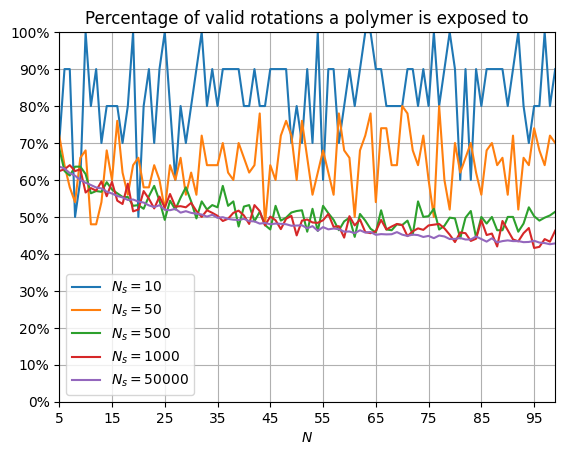

In [135]:
# plot the results for the cell above
fig, ax = plt.subplots()

for i, _percentages in enumerate(percentages):
    ax.plot(N, _percentages, label=f"$N_s = {N_s[i]}$")

ax.set(
    xlabel="$N$",
    ylabel="",
    xlim=(5,N[-1]),
    ylim=(0, 1),
    xticks=np.arange(N_lower,N_upper,10),
    yticks=np.arange(0,1.1,0.10),
    title="Percentage of valid rotations a polymer is exposed to"
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.legend()
ax.grid()
plt.show()

From the graph we see that a higher $N_s$ gives lower volatility. For $N_s = 10$ and $N_s = 50$ the randomness is prominent. Larger values for $N_s$ gives more rotations and thus each rotation matter less for the total percentage. This gives rise to the smoothing of the graph.
It is noteworthy that the percentage of valid rotations decreases as $N$ increases, but seems to converge to some value around $43 \%$.

### Energy
The energy of the polymer is defined as follows:

$$
    E = \frac{1}{2} \sum_{m, n} V_{mn} b_{mn}
$$

The $N\times N$-matrix $V$ is a constant while the quantity $b_{mn}$ has to be calculated for each step:

\begin{equation}
 b_{mn} =
  \begin{cases}
  1 & m \text{ and } n \text{ closest neighbours} \\
  0 & \text{otherwise} 
  \end{cases}
\end{equation}

A function to generate the $V$-matrix proves to be useful.

In [136]:
def gen_V_matrix(
    size: int, fill_value: float | tuple[float, float] = -1.0
) -> np.ndarray:
    """
    With fill_value = -1.0 gen_V_matrix generates a size*size matrix:
         0  0 -1 -1 ... -1 -1 -1
         0  0  0 -1 ... -1 -1 -1
        -1  0  0  0 ... -1 -1 -1
        .          .           .
        .            .         .
        .              .       .
        -1 -1 -1 -1 ...  0  0  0
        -1 -1 -1 -1 ... -1  0  0

    Args:
        size: size of array
        fill_value: float | tuple[lower, upper]
            if fill_value is a 2-tuple then 
            the fill_values are drawn from
            a uniform distribution on [lower, upper].

    Returns:
        the matrix
    """
    if type(fill_value) == float:
        V = np.full((size, size), fill_value)

    else:
        assert len(fill_value) == 2, "There is an error in the type of fill_value"
        rng = np.random.default_rng()
        V = np.zeros((size, size))
        for i in range(1, size):
            for j in range(i):
                value = rng.uniform(fill_value[0], fill_value[1])
                V[i, j] = value
                V[j, i] = value

    # filling the diagonals with zeros can be done in the for-loops,
    # but this is easier to read and is more foolproof
    np.fill_diagonal(V, 0)
    np.fill_diagonal(V[:-1, 1:], 0)
    np.fill_diagonal(V[1:, :-1], 0)
    
    return V

`calculate_energy` also has to be optimized for speed in the same manner as `check_if_intact` and `rotate_polymer`.

The most time consuming part of calculate_energy is to fill the $b$-matrix based on which monomers are neighbours. 
We wrote two implementations that both have their strengths and weaknesses. The first one, `calculate_energy_1`, exploits the 
symmetry of the problem and only fills the lower half of the $b$-matrix, as it is a symmetric matrix otherwise. This roots in the fact that if monomers $m$ and $n$ are closest neighbours, then monomers $n$ and $m$ are also closest neighbours.
This way it never checks the same two monomers twice. A slight optimalization is to also never check the the next monomer in 
the chain, as they will never interact with each other, making the check redundant.
This results 
in fewer memory writes and no double counting. The downside of this method is that it uses python `for`-loops. The other 
method, `calculate_energy`, uses *NumPy* operations exclusively for speed of computation, but has the downside that it uses 
more memory and checks the same pair of monomers twice. However, for the polymer sizes we operate with, the extra memory 
usage should be negligible.

In [137]:
@njit()
def calculate_energy_1(polymer: np.ndarray, V: np.ndarray) -> float:
    """Calculates the energy of the given polymer.

    Args:
        polymer: A 2D numpy array with monomer coordinates

        V: A matrix with the strength of the interaction between monomers of the given polymer.
        V[i, j] = V[j, i] = strength between monomer number (i+1) og (j+1)

    Returns:
        The energy of the polymer
    """
    N = len(polymer)
    # A matrix which tells if monomer (i+1) and (j+1) are neighbours. b_matrix[i, j] = 1 if they are, and 0 otherwise
    b_matrix = np.zeros((N, N))
    for i in range(0, N):
        # We only need to look at monomer combinations which we have not checked yet.
        # The next monomer in the polymer does not interact with the given monomer, so we don't have to check it.
        for j in range(i + 2, N):
            # Only "closest neighbour"-coordinates will give a euclidian distance of exactly one, so we dont have to take the square root.
            if np.sum((polymer[i] - polymer[j]) ** 2) == 1:
                # We only need to fill the lower triangle of the matrix, as it otherwise will just be symmetric.
                # Note: j>i
                b_matrix[j, i] = 1
    # Don't have to divide by two, because we only filled the lower triangle of the b_matrix.
    # We don't count the same interaction twice
    return float(np.sum(V * b_matrix))

In [138]:
@njit
def calculate_energy(polymer: np.ndarray, V: np.ndarray) -> float:
    """Calculates the energy of the given polymer.
    
     Args:
        polymer: A 2D numpy array with monomer coordinates

        V: A matrix with the bonding energies for the monomers of the given polymer.
        V[i, j] = V[j, i] = bonidng energy for the bond between monomer number (i+1) and (j+1).

    Returns:
        The energy of the polymer"""
    N = len(polymer)
    L = np.repeat(polymer, N).reshape(2 * N, N)
    b = np.where(
        ((L[::2] - L[::2].transpose()) ** 2 + (L[1::2] - L[1::2].transpose()) ** 2)
        == 1,
        1,
        0
    )
    return 0.5 * (np.sum(V * b))

An explanation of the inner workings of `calculate_energy` is found at the end.<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

#### `calculate_energy` benchmarks

In [139]:
N = 35
Ns = 1000
V = gen_V_matrix(N)
polymer, _ = simulate_rotations(N, Ns)

print("\ncalculate_energy")
%timeit calculate_energy(polymer, V)

print("\ncalculate_energy_1")
%timeit calculate_energy_1(polymer, V)


calculate_energy
18.1 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

calculate_energy_1
48.9 µs ± 22.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note that for the first run (remember to restart the kernel) both `calculate_energy` and `calculate_energy_1` has high 
standard deviations.
For `calculate_energy` timeit even gives this warning: "This could mean that an intermediate result is being cached".
Running the cell a second time however, shows that `calculate_energy` is faster than `calculate_energy_1`.
This is due to *Numba*'s Just In Time compilation. When the function is called the first time *Numba* compiles to machine code 
such that the subsequent calls are faster.

What is interesting is that `calculate_energy` is faster than `calculate_energy_1`, even though `calculate_energy_1` does 
less than half the number of operations of `calculate_energy`. This only goes to show how slow python really is compared to 
lower level languages.

#### Using `calculate_energy`

Let us fill the $V$-matrix with $-1$ and calculate the energy for the two polymers generated [earlier](#Simulation):

In [140]:
N = 15
V = gen_V_matrix(size = N, fill_value = -1.0)
E_1 = calculate_energy(polymer_1, V)
E_2 = calculate_energy(polymer_2, V)

print(f"Energy_1: {E_1}\nEnergy_2: {E_2}")

Energy_1: 0.0
Energy_2: -1.0


Looking at the [visualizations](#simulation_visualization) for the two polymers we see that `polymer_2` has a twist at the end with two non-consecutive monomers being closest neighbours. This results in a lower energy because the entries of V are negative. Therefore the resulting 
energies $E_1 = 0.0$ and $E_2 = -1.0 $ are as expected. 


---

Now that the basic functionality has been implemented and tested for speed it is time to run some larger simulations!

## Larger simulations and investigations of physical quantities

`metropolis` is our implementation of the metropolis algorithm for the problem at hand.

In [141]:
@njit
def metropolis(
    pol: np.ndarray, N_s: int, V: np.ndarray, T: float
) -> tuple[np.ndarray, np.ndarray]:
    """Runs the Metropolis-algorithm

    Args:
        pol: Polymer initial state
        N_s: Rotation attempts
        V: Interaction forces between two monomers
        T: Temperature (Kelvin)

    Returns:
        (Last polymer created, array with all simulated energies)
    """
    E_array = np.zeros(N_s)
    N = len(pol)
    E = calculate_energy(pol, V)
    i = 0
    while i < N_s - 1:
        # random monomer and random twisting direction
        # [2, N) makes sure the end monomers are not chosen as rotation centers
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        twisted_pol = rotate_polymer(pol, rnd_monomer, rnd_rotate)
        if check_if_intact(twisted_pol, N):
            i += 1
            E_new = calculate_energy(twisted_pol, V)

            if E_new < E:
                pol = twisted_pol
                E = E_new

            elif np.random.uniform() < np.exp(-(E_new - E) / (T * Boltzmann)):
                pol = twisted_pol
                E = E_new
            E_array[i] = E

    return pol, E_array

<a id="metropolis_first_simulation"></a>
#### First simulation and temperature dependance

Let us run two simulations of `metropolis`.

We fixate $N = 30$, $N_s = 5000$ and

$$V =
  \begin{bmatrix}
   0& 0 & & &  &  & & &\\
   0& 0 & 0 & &  &  −4.0&  \cdot& 10^{−21} &\text{J}\\
   & 0 & 0 & 0 &  &  &  &  & \\
   &  & 0 & 0 &  &  &  &  & \\
   &  &  &  &  \ddots&  & &  & \\
   &  &  &  &  &  0&  0&  & \\
   &  &  &  &  &  0&  0&  0& \\
   −4.0&  \cdot& 10^{−21} &\text{J}  &  &  &  0&  0& 0\\
   &  &  &  &  &  &  &  0& 0\\
  \end{bmatrix}$$

In order to look at how the temperature affects the polymer we use the following values:

\begin{align}
T_\text{low} &= 70 \,\text{K} \\
T_\text{high} &= 350 \,\text{K}
\end{align}

In [142]:
# Define constants
N = 30
Ns = 5000
V = gen_V_matrix(size=N, fill_value=-4e-21)
T_low = 70
T_high = 350

# run the simulation
polymer_low, E_low = metropolis(generate_flat_polymer(N), N_s=Ns, V=V, T=T_low)
polymer_high, E_high = metropolis(generate_flat_polymer(N), N_s=Ns, V=V, T=T_high)

Plotting the energy $E$ as function of iteration step $t$ for the two temperatures.

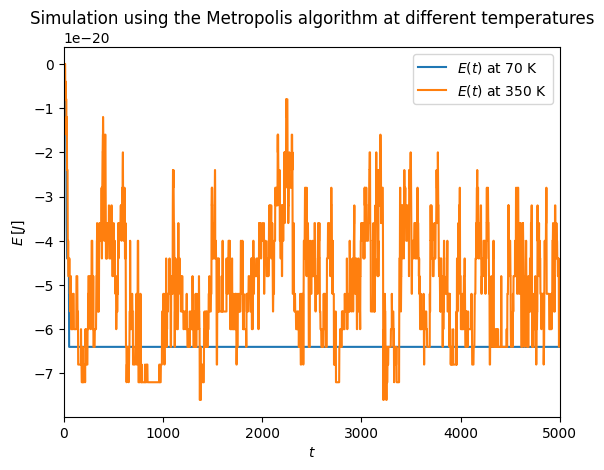

In [143]:
# Plot the results
fig, ax = plt.subplots()

ax.plot(E_low, label=f"$E(t)$ at ${T_low}$ K")
ax.plot(E_high, label=f"$E(t)$ at ${T_high}$ K")

ax.legend()
ax.set(
    title="Simulation using the Metropolis algorithm at different temperatures",
    xlabel="$t$",
    ylabel="$E\,[J]$",
    xlim=(0,Ns)
)
plt.show()


It is clear from the plot that increasing the temperature results in the polymer occupying more energy states.
Therefore it has a higher probability of exploring the states that has the lowest energy.
Due to the high temperature the polymer is more "wiggly" and thus has a lower probability of getting stuck in a local minima.
The polymer at the lower temperature struggles to get out of such wells and thus the graph of the energy function is flatter.

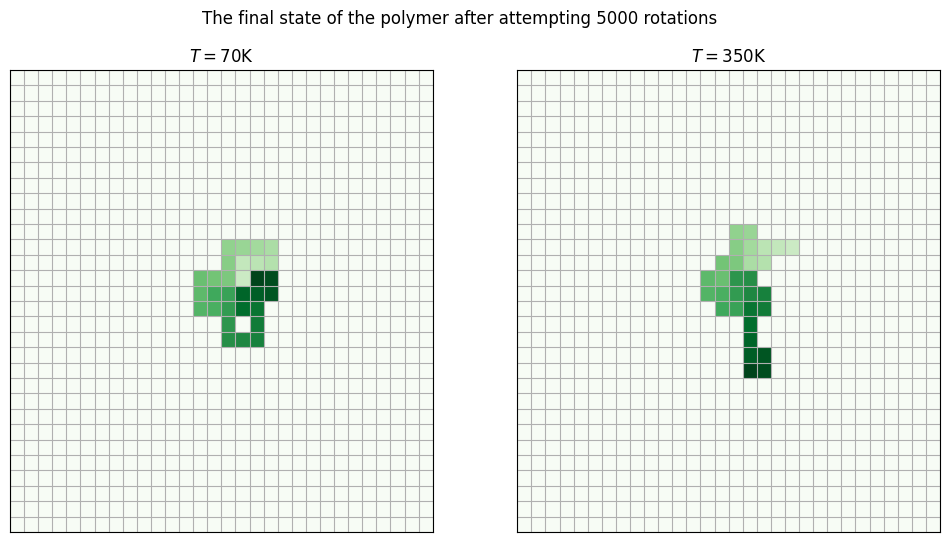

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
illustrate_polymer(axs[0], polymer_low, cmap="Greens", title=f"$T = {T_low} $K")
illustrate_polymer(axs[1], polymer_high, cmap="Greens", title=f"$T = {T_high} $K")
fig.suptitle(f"The final state of the polymer after attempting {Ns} rotations")
plt.show()

It is difficult to extract useful information from looking at a single iteration of a stochastic simulation.
The rotations (and thus the energy levels) are subject to randomness.
However, analyzing the distribution of the energies ($E(t)$) provides insights about the system.

Looking at the final positions of the polymers above we see that the polymer on the left side has curled itself into a tight ball, while the polymer on the right is comparatively more stretched out. This result is plausible given that higher temperature results in the polymer exploring more states.

Even though this was the result at the time of writing, the next run will produce a different result.

### Understanding the $V$-matrix

The $V$-matrix holds information about how different monomers interact with each other.
Using different matrices (ensuring that they remain symmetric) one can model proteins with different structures.
Let us experiment a bit with the setup of $V$:

- **Setup 1**\
  Instead of using negative entries in $V$ as in the [previous](#metropolis_first_simulation) simulation we now choose the entries to be positive.
  The physical interpretation of this is that the monomers now repel each other and we therefore expect the polymer to stay pretty flat.

- **Setup 2**\
  Scaling all entries by a factor of $100$ and setting the signs of entries at the upper right and lower left corners to be negative and all other entries to be positive.
  By doing this we expect the polymer to form a ring since the middle monomers are repelling and the ends are attracting.
  The chance of getting a ring increases if we give the polymer enough time (setting $N_s$ to be large enough) and make the ends "sticky" (by scaling the entries of $V$).

- **Setup 3**\
  In the last setup we scale a single entry in $V_{1k}$ by a factor of $100$ (making sure the matrix is symmetric by also scaling $V_{k1}$).
  Interpreting the entry $V_{mn}$ as the "bonding strength" between monomers $m$ and $n$ we would expect that once the monomers $1$ and $k$ comes in contact they will remain in contact for the rest of the simulation. Let's fixate $k$ to be $\lfloor N / 2 \rfloor$.
    
In order to look at these cases we will run `metropolis` on a polymer of length 30 at temperature $T = 150$ K and visualize the resulting polymers and energy functions.

In [145]:
# Defining constants
N = 30
Ns = 5000
scaling = 100
T = 150
fill_value = -4e-21

# Creating the matrices
# setup 1
V1 = gen_V_matrix(size=N, fill_value=-fill_value)

# setup 2
V2 = gen_V_matrix(size=N, fill_value=fill_value*scaling)
for i in range(2, N-2):
    np.fill_diagonal(V2[:-i, i:], -fill_value*scaling)
    np.fill_diagonal(V2[i:, :-i], -fill_value*scaling)

# setup 3
V3 = gen_V_matrix(size=N, fill_value=fill_value)
V3[0, int(N/2)] *= scaling
V3[int(N/2), 0] *= scaling

# running the simulation
pol1, E_array1 = metropolis(pol=generate_flat_polymer(N), N_s=Ns, V=V1, T=T)
pol2, E_array2 = metropolis(pol=generate_flat_polymer(N), N_s=Ns, V=V2, T=T)
pol3, E_array3 = metropolis(pol=generate_flat_polymer(N), N_s=Ns, V=V3, T=T)

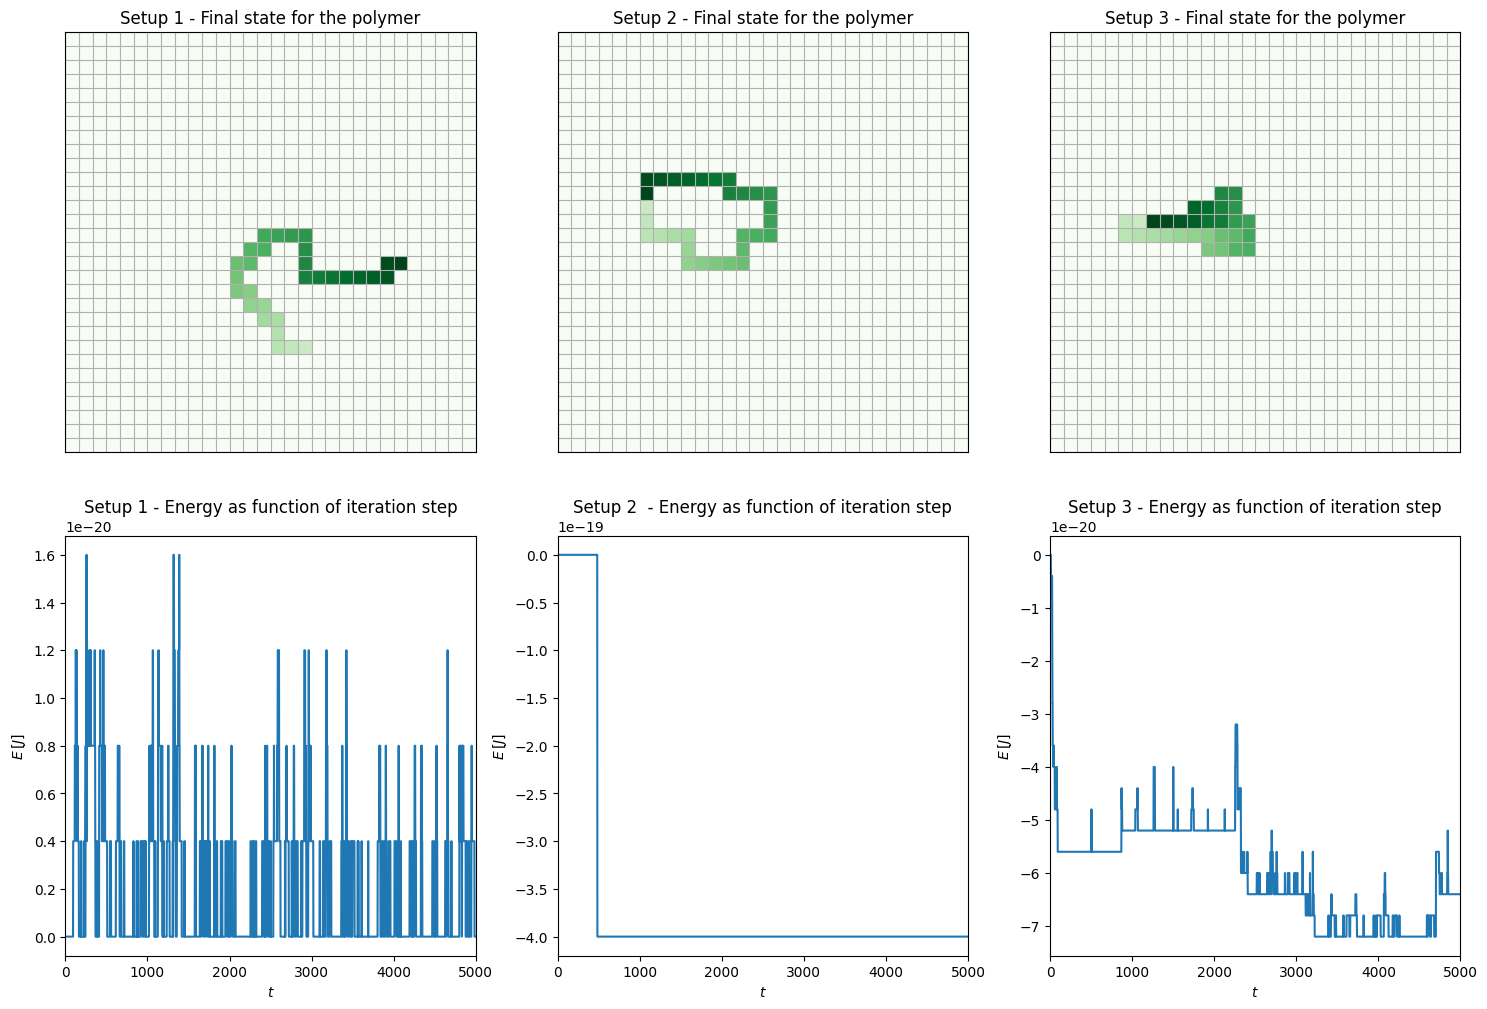

In [146]:
# plot and visualization for the cell above
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs[1, 0].plot(
    E_array1
)
axs[1, 1].plot(
    E_array2
)
axs[1, 2].plot(
    E_array3
)
axs[1, 0].set(
    title="Setup 1 - Energy as function of iteration step",
    xlabel="$t$",
    ylabel="$E\,[J]$",
    xlim=(0,Ns)
)
axs[1, 1].set(
    title="Setup 2  - Energy as function of iteration step",
    xlabel="$t$",
    ylabel="$E\,[J]$",
    xlim=(0,Ns)
)
axs[1, 2].set(
    title="Setup 3 - Energy as function of iteration step",
    xlabel="$t$",
    ylabel="$E\,[J]$",
    xlim=(0,Ns)
)

illustrate_polymer(axs[0, 0], pol1, cmap="Greens", title="Setup 1 - Final state for the polymer")
illustrate_polymer(axs[0, 1], pol2, cmap="Greens", title="Setup 2 - Final state for the polymer")
illustrate_polymer(axs[0, 2], pol3, cmap="Greens", title="Setup 3 - Final state for the polymer")

plt.show()

Looking at setup $1$'s energy plot we see that $E$ mostly remain at the lower energy steps ($0$ J and $4.0 \cdot 10^{-21}$ J). For the chosen temperature we see some fluctiations, but the polymer generally keeps its flat profile.

On the contrary, in setup 2 the polymer har formed a ring. The energy function also clearly shows that once the ends bond, they stay bonded.
The exact form of the ring is subject to the random rotations that took place before the bonding.

Energy considerations of setup 3 resembles that of setup 2, but has fluctiations after the bonding has occured.
Predicting the form of the polymer is more difficult, but we would at least expect monomers $1$ and $k$ to be closest neighbours. This is clearly the case.

### Energy and it's dependance on temperature

By running `metropolis` over a range of temperatures we can calculate $<E>(T)$ and $\sigma_E(T)$.
Because all polymers starts out as flat polymers we exclude the first $1000$ steps of each simulation.
This is such that the polymers' starting position do not affect $<E>(T)$.

In [147]:
# Defining constants
T_interval = np.arange(10, 1000, 30)
N = 30
Ns = (1050, 5000, 50_000)
V = gen_V_matrix(N, fill_value=-4e-21)

# Preparing arrays
E_mean = np.zeros((len(Ns), len(T_interval)))
E_std = np.zeros((len(Ns), len(T_interval)))

# running metropolis for all Ts in T_interval and calculating the mean and standard deviation.
for i, _Ns in enumerate(Ns):
    for j, T in enumerate(T_interval):
        pol = generate_flat_polymer(N)
        pol, E_array = metropolis(pol=pol, N_s=_Ns, V=V, T=T)
        E_mean[i, j] = np.mean(E_array[1000:])
        E_std[i, j] = np.std(E_array[1000:])

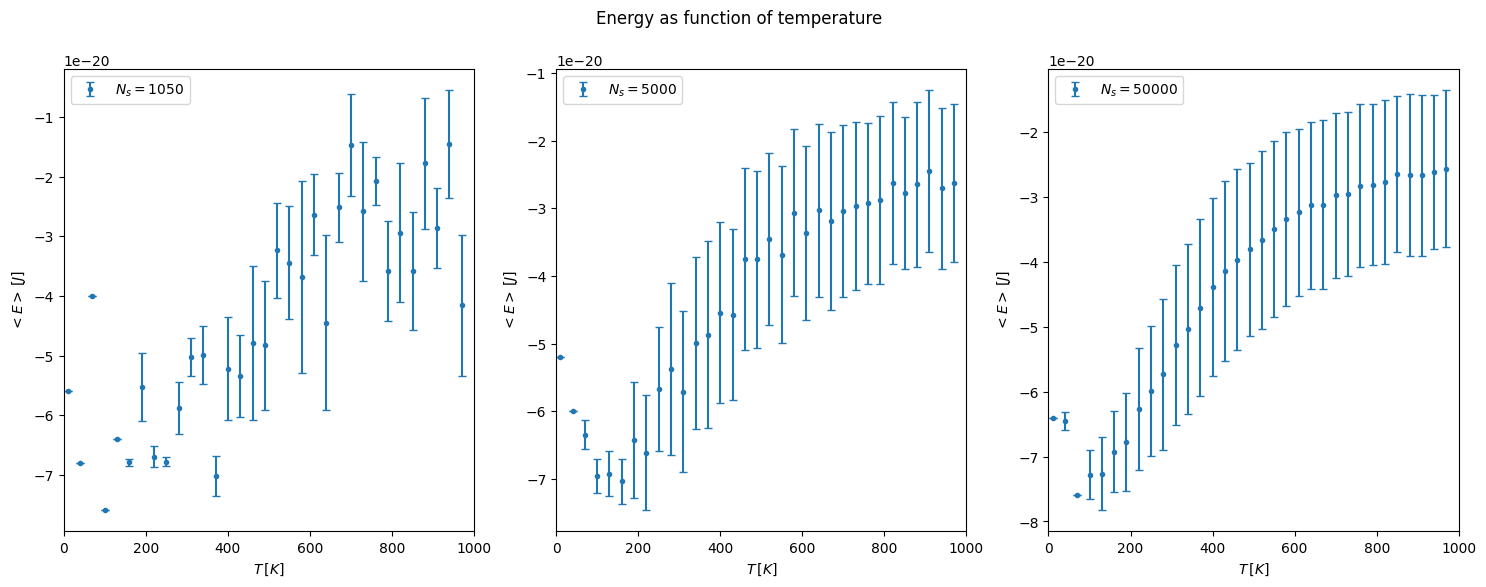

In [148]:
fig, axs = plt.subplots(1, len(Ns), figsize=(6*len(Ns), 6))

for i, _Ns in enumerate(Ns): 
    axs[i].errorbar(
        T_interval,
        E_mean[i],
        yerr=E_std[i],
        fmt=".",
        capsize=3,
        label=f"$N_s = {_Ns}$"
    )
    axs[i].set(
        xlabel="$T\,[K]$",
        ylabel="$<E>\, [J]$",
        xlim=(0, 1000)
    )
    axs[i].legend()

fig.suptitle("Energy as function of temperature")
plt.show()

Increasing $N_s$ seems give rise to a smoothing effect of the energy expectation value and its deviation.
One can explain this by interpereting $<E>$ as an estimator for the expectation value of the energy.
Since $\frac{1}{N_s} \sum_t E(t)$ converges to $\text{E}[E]$ as $t \to \infty$, increasing $N_s$ would then give more accurate results.

However, at lower temperatures the standard deviation is lower and suggests that the polymer gets "stuck" in a local minima.
From the above plots the energy seems to be lowest at around $150$ K, but running the simulation multiple times give different results for lower temperatures.

#### Energy at lower temperatures

Let us take a closer look at $T = 70$ K by running $10$ simulations at this temperature and plot $E(t)$.

In [149]:
# Defining constants
T = 70
num_simulations = 10
N = 30
Ns = 5000
V = gen_V_matrix(N, fill_value=-4e-21)

# Preparing array
E_array_array = np.zeros((num_simulations, Ns))

for i in range(num_simulations):
    pol = generate_flat_polymer(N)
    pol, E_array = metropolis(pol=pol, N_s=Ns, V=V, T=T)
    E_array_array[i] = E_array

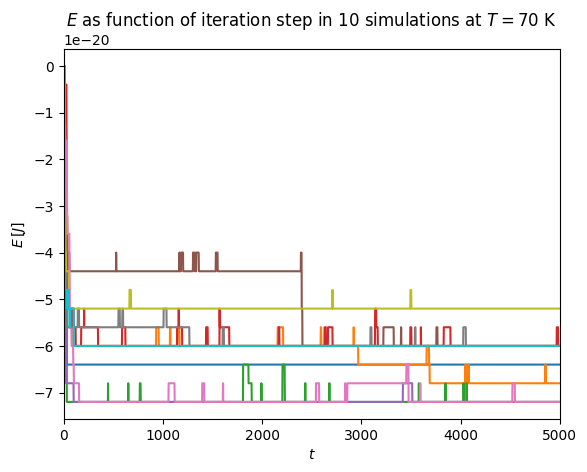

In [150]:
# plots the results from the cell above
fig, ax = plt.subplots()
for E_arr in E_array_array:
    ax.plot(E_arr)

ax.set(
    title="$E$ as function of iteration step in $10$ simulations at $T = 70$ K",
    xlabel="$t$",
    ylabel="$E\,[J]$",
    xlim=(0, Ns)
)
plt.show()

From the plot above, we can see that polymers at low temperatures tend to be quite stable once they have reached a reasonably 
low energy state. With the exception of the initial steps, the polymers energies plateaus at a lower energy state than the 
initial energy, where they tend to stay for the rest of the simulation. We also observe that the different polymers do not 
stabilize at the same energy level, but rather at comparatively big energy differences between each other. This indicates 
that after the initial steps, the polymers gets locked into a local energy minima where they may randomly fluctuate to a 
small extent above the minima, but rarely enough escape it. If they do escape it, they tend to drop to an even
lower energy level where they stabilize themselves again.

The fact that they stabilize at different energy levels is important to note, as it makes determining the average energy of a 
polymer at low temperatures with only one simulation insufficient. Because the polymer falls into different local minimas
during the initial steps, we need to simulate several polymers to explore the different minimas. From this we can make an 
estimate of the average energy by taking the empirical average over all the simulations. With this method we will be
able to get a more accurate result as opposed to just running one simulation.

### How about the polymers spacial extent?

The diameter of a polymer is defined as the largest euclidean distance between two unique monomers.

`calculate_diameter` calculates all the distances between the monomers before returning the largest distance.

In [151]:
@njit  
def calculate_diameter(polymer: np.ndarray) -> float:
    """Finds the diameter of a polymer

    Args:
        polymer (np.ndarray): the polymer to find the diameter of

    Returns:
        float: diameter of the polymer
    """
    N = len(polymer)
    L = np.repeat(polymer, N).reshape(2 * N, N)
    return np.sqrt(
        np.max(
            (L[::2] - L[::2].transpose()) ** 2 + (L[1::2] - L[1::2].transpose()) ** 2
        )
    )


This is the implementation of the metropolis algorithm with the diameter calculation integrated.

In [152]:
@njit
def metropolis_diameter(
    pol: np.ndarray, N_s: int, V: np.ndarray, T: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Metropolis algorithm with diameter calculation

    Args:
        pol: polymer start shape
        N_s: Number of attempts at rotation
        V: Interaction between monomers
        T: temperature in kelvin

    Returns:
        (output array, array with all energies, array with all diameters)
    """
    E_array = np.zeros(N_s)
    Dia_array = np.zeros(N_s)
    N = len(pol)
    E = calculate_energy(pol, V)
    i = 0
    while i < N_s - 1:
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        twisted_pol = rotate_polymer(pol, rnd_monomer, rnd_rotate)
        if check_if_intact(twisted_pol, N):
            i += 1
            E_new = calculate_energy(twisted_pol, V)

            if E_new < E:
                pol = twisted_pol
                E = E_new
            
            elif np.random.uniform() < np.exp(-(E_new - E) / (T * Boltzmann)):
                pol = twisted_pol
                E = E_new
            E_array[i] = E
            Dia_array[i] = calculate_diameter(pol)

    return pol, E_array, Dia_array

Simulating rotation and diameter for different temperatures, with a flat polymer generated as the starting point for each temperature.

The last simulation goes through the temperature array from high to low, and uses the resulting polymer from the previous temperature as the starting polymer for the next temperature.   
This process best describes cooling down a polymer.

As with the energy simulations we exclude the first $1000$ rotations.

We chose $N_s$ as $50000$, which is sufficiently large to give stable results for average and sandard deviation, but does not cause the simulations to take too much time.

In [153]:
# Defining constants
T_interval = np.arange(10, 1000, 30)
N = 30
Ns = 50_000
V = gen_V_matrix(N, fill_value=(-6*10**(-21), -2*10**(-21))) 


E_mean = np.zeros(len(T_interval))
E_std = np.zeros(len(T_interval))

d_mean = np.zeros(len(T_interval))
d_std = np.zeros(len(T_interval))

E_rep_mean = np.zeros(len(T_interval))
E_rep_std = np.zeros(len(T_interval))

d_rep_mean = np.zeros(len(T_interval))
d_rep_std = np.zeros(len(T_interval))

T_rep_interval = np.flip(T_interval)

start_2g = time.perf_counter()
for i, T in enumerate(T_interval): # Runs metropolis for t_interval
        pol = generate_flat_polymer(N)
        pol, E_array, d_array = metropolis_diameter(pol=pol, N_s=Ns, V=V, T=T)

        d_mean[i] = np.mean(d_array[1000:])
        d_std[i] = np.std(d_array[1000:])

        E_mean[i] = np.mean(E_array[1000:])
        E_std[i] = np.std(E_array[1000:])
        
end_2g = time.perf_counter() - start_2g
print(f"Time for all simulations(task 2g): {end_2g:.2f} seconds")

pol_rep = generate_flat_polymer(N) # Starting polymer for the reversed temperature
for i, T in enumerate(T_rep_interval): # runs metropolis for the reversed temperatures
        pol_rep, E_array, d_array = metropolis_diameter(pol=pol_rep, N_s=Ns, V=V, T=T)

        d_rep_mean[-i-1] = np.mean(d_array[1000:])
        d_rep_std[-i-1] = np.std(d_array[1000:])

        E_rep_mean[-i-1] = np.mean(E_array[1000:])
        E_rep_std[-i-1] = np.std(E_array[1000:])


Time for all simulations(task 2g): 36.36 seconds


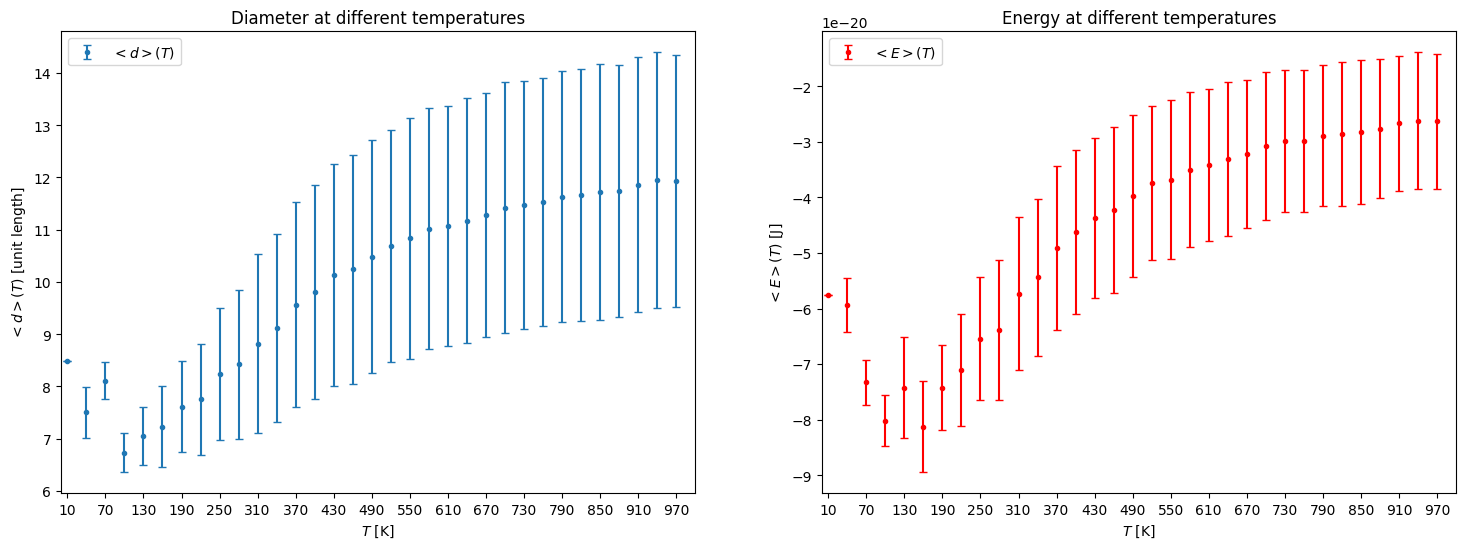

In [159]:
# Plotting the diameter for different temperatures.
fig, (ax1, ax2) = plt.subplots(nrows= 1, ncols=2, figsize = (18, 6))

ax1.errorbar(
    T_interval,
    d_mean,
    yerr=d_std,
    fmt=".",
    capsize=3,
    label=r"$<d>(T)$"
)

ax1.set(
    title="Diameter at different temperatures",
    xlabel="$T$ [K]",
    ylabel="$<d>(T)$ [unit length]",
    xticks=T_interval[::2],
    xlim=(0,1000)
)

ax2.errorbar(
    T_interval,
    E_mean,
    yerr=E_std,
    fmt=".",
    capsize=3,
    label=r"$<E>(T)$",
    color = "r"
)

ax2.set(
    title="Energy at different temperatures",
    xlabel="$T$ [K]",
    ylabel="$<E>(T)$ [J]",
    xticks=T_interval[::2],
    xlim=(0,1000)
)

ax1.legend()
ax2.legend()

plt.show()



Total runtime of all simulations: $36.36$ sec.

The diameter of the polymer follows a similar pattern to the energy of the polymer. A high energy gives a large diameter, which is expected since contact between monomers gives lower energy and a large diameter means that less monomers are in contact with eachother.

The diameter is large at high temperatures and decreases until around reaches a certain temperature before it doesn't follow any pattern and becomes more random. This makes sense given that at lower temperatures it is easier for the polymer to get "stuck" in a local energy minima and the minima it gets "stuck" in is random.


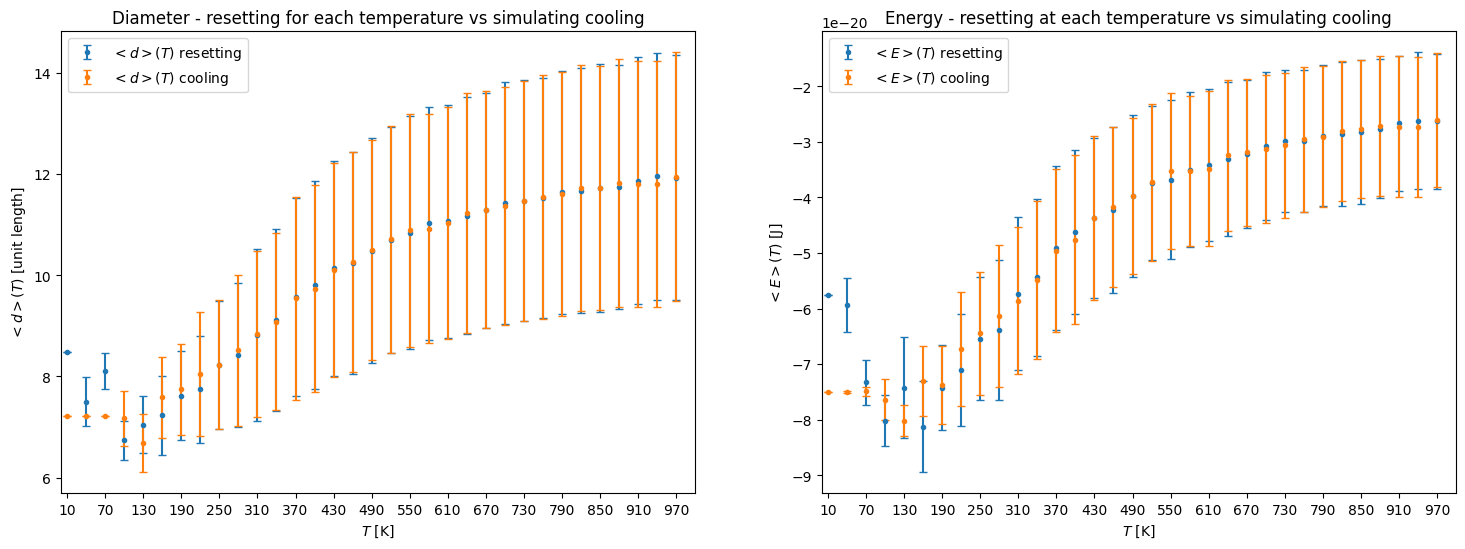

In [160]:
# Plotting cooling and different temperatures in the same plot 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax1.errorbar(
    T_interval,
    d_mean,
    yerr=d_std,
    fmt=".",
    capsize=3,
    label=r"$<d>(T)$ resetting"
)
ax1.errorbar(
    T_interval,
    d_rep_mean,
    yerr=d_rep_std,
    fmt=".",
    capsize=3,
    label="$<d>(T)$ cooling"
)
ax1.set(
    title="Diameter - resetting for each temperature vs simulating cooling",
    xlabel="$T$ [K]",
    ylabel="$<d>(T)$ [unit length]",
    xticks=T_interval[::2],
    xlim=(0,1000)
)

ax2.errorbar(
    T_interval,
    E_mean,
    yerr=E_std,
    fmt=".",
    capsize=3,
    label=r"$<E>(T)$ resetting"
)

ax2.errorbar(
    T_interval,
    E_rep_mean,
    yerr=E_rep_std,
    fmt=".",
    capsize=3,
    label="$<E>(T)$ cooling"
)

ax2.set(
    title="Energy - resetting at each temperature vs simulating cooling",
    xlabel="$T$ [K]",
    ylabel="$<E>(T)$ [J]",
    xticks=T_interval[::2],
    xlim=(0,1000)
)

ax1.legend()
ax2.legend()
plt.show()

The polymer that undergoes cooling ends up having an almost constant diameter for the lowest temperatures.  
This can be seen by there being very little standard deviation. This is reasonable since the polymer most likely has hit an energy minima before it reaches the lowest temperatures, therefore it will not rotate at all since the energy already is minimized. 

To see the behavior of the polymer at low temperatures, the process of cooling would be best to simulate a polymer that is created at a higher temperature and then cooled down.
If one wants to see what the behaviour of a polymer that is created at an already low temperature, the method of creating a flat polymer for every temperature would be best, since it does not enter the low temperatures with an already established energy minima. 

At high temperatures the polymer will be very unstable, and both methods should be good since they both give variation in energy and diameter, which the plot shows. They both have high standard deviations and the averages are rather similar for higher temperatures.

---
### Conclusion

By using Monte Carlo simulation of polymer folding we have arrived at the conclusion that there is a clear relationship 
between temperature, 
energy, and the polymer diameter.
If starting at low temperatures, the energy of the polymer appear random as a consequence of being trapped in 
local energy minimas. By increasing the temperature, the energy first dips before monotonically increasing with 
temperature. The dip can be explained by the fact that when increasing the temperature, the polymer gains enough energy to 
escape the local energy minima it was trapped in.
This is supported by starting the simulation at higher temperatures and then cooling the polymer, it was found that when the temperature hit a certain temperature range, the energy remains constant for the cooling process.
The diameter's dependence on temperature closely mimics that of the energy.
Simulating polymer folding has posed a challenge when it comes to the use of processing power.
Utilizing *Numba* and *NumPy* has made the code substantially quicker, 
enabling us to use larger and better simulations without taking too much time.

---

<a name="cite_note-1"></a>1. [^](#cite_ref-1)

A closer look at `calulate_energy`'s use of *NumPy*-arrays:

```python
def calculate_energy(polymer: np.ndarray, V: np.ndarray) -> float:
    """Calculates the energy of the given polymer.
    
     Args:
        polymer: A 2D numpy array with monomer coordinates

        V: A matrix with the bonding energies for the monomers of the given polymer.
        V[i, j] = V[j, i] = bonidng energy for the bond between monomer number (i+1) and (j+1).

    Returns:
        The energy of the polymer"""
    N = len(polymer)
    L = np.repeat(polymer, N).reshape(2 * N, N)
    b = np.where(
        ((L[::2] - L[::2].transpose()) ** 2 + (L[1::2] - L[1::2].transpose()) ** 2)
        == 1,
        1,
        0
    )
    return 0.5 * (np.sum(V * b))
```

`calculate_energy` first creates a matrix $L$, which after `numpy.repeat().reshape()` will look as follows:

$$
  \begin{bmatrix}
  x_1 & x_1 &\dots  &x_1 \\
   y_1& y_1 &\dots  &y_1 \\
   x_2& x_2 & \dots &x_2 \\
   y_2& y_2 &\dots  &y_2 \\
   \vdots& \vdots & \ddots &\vdots \\
   y_{N-1}& y_{N-1} & \dots &y_{N-1} \\
   x_N& x_N & \dots & x_N\\
   y_N& y_N & \dots &y_N \\
  \end{bmatrix}
$$

This allows us to exploit *NumPy*'s efficient slicing.

By slicing $L$ we get these matrices:

`L[::2]`:

$$
  \begin{bmatrix}
  x_1 & x_1 &\dots  &x_1 \\
   x_2& x_2 & \dots &x_2 \\
   \vdots& \vdots & \ddots &\vdots \\
   x_{N-1}& x_{N-1} & \dots &x_{N-1} \\
   x_N& x_N & \dots & x_N\\
  \end{bmatrix}
$$

`L[1::2]`:
$$
  \begin{bmatrix}
   y_1& y_1 &\dots  &y_1 \\
   y_2& y_2 &\dots  &y_2 \\
   \vdots& \vdots & \ddots &\vdots \\
   y_{N-1}& y_{N-1} & \dots &y_{N-1} \\
   y_N& y_N & \dots &y_N \\
  \end{bmatrix}
$$

`L[::2].transpose()`:
$$
  \begin{bmatrix}
    x_1 & x_2 &\dots  &x_{N-1} &x_N \\
   x_1& x_2 & \dots &x_{N-1}&x_N \\
   \vdots& \vdots & \ddots & \vdots&\vdots \\
   x_1& x_2 & \dots &x_{N-1}&x_N \\
   x_1& x_2 & \dots &x_{N-1}& x_N\\
  \end{bmatrix}
$$

`L[1::2].transpose()`:
$$
  \begin{bmatrix}
    y_1 & y_2 &\dots  &y_{N-1} &y_N \\
   y_1& y_2 & \dots &y_{N-1}&y_N \\
   \vdots& \vdots & \ddots & \vdots&\vdots \\
   y_1& y_2 & \dots &y_{N-1}&y_N \\
   y_1& y_2 & \dots &y_{N-1}& y_N\\
  \end{bmatrix}
$$


We now see that the following equation yields a matrix $b$ where the $b_{mn}$ is the euclidian distance between monomer $m$ and $n$.
```python
((L[::2] - L[::2].transpose()) ** 2 + (L[1::2] - L[1::2].transpose()) ** 2)
```

Comparing $b_{mn}$ with $1$ in `numpy.where()` yields $b$ where

\begin{equation}
 b_{mn} =
  \begin{cases}
  1 & m \text{ and } n \text{ closest neighbours} \\
  0 & \text{otherwise} 
  \end{cases}
\end{equation}
